# Load Balancing Example

In this example we're going to show how you could use various approaches to solve a load balancing problem. Load balancing is when you want to divide a workload as evenly as possible among a set of resources. If we're talking execution times on computer processors, we can describe it as:

given a list of $n$ execution times, divide them to be executed on $k$ processors so that the total execution time on each processor is as close to the same as possible.

Let's look at a quick example to illustrate this. Say we had 4 jobs that needed to execute and they had the following times: [2,2,4,4]

If we had 2 servers (each with 1 processor) to divide them between, we could have one processor do [2,2] and one processor do [2,4] or we could have each processor do [2,4]. (We could also have one processor doing [2,2,4] and one doing [4], but we'll keep it simple for this example.)

Our objective function is total squared deviation of execution times from balanced time. What does that mean? Well, balanced time is when the total execution time on each processor is the same as every other processor. But, if our loads are out of balance, some processors will be doing much more work. We want to know the difference between what each processor would run if things were in balance and what they are actually running.

Given $s$ is the sum of all execution times, and $k$ is the number of processors, determing our objective function by hand would look like this:

<img src="images/startloadbalancing.png"/>

If we were perfectly load balanced, it would look like this:

<img src="images/endloadbalancing.png"/>

Let's dive into working out this same problem in Python.

First we'll set our times as a numpy array and we'll create an objective function that does all our calculations for us. In order for the objective function to work, we need to know how to assign each job to a processor. We'll create another numpy array that has the number of the processor to assign to, and we'll use index filtering to fetch each "set" of processing times. (We'll walk you through what we're talking about in the comments below.)

In [1]:
import numpy as np
import pandas as pd

#set our execution times
times = np.array([2,4,2,4])
#set our number of servers
k = 2

#set up an array that assigns each execution time to a one of the processors
assign = np.array([0,1,0,1])
#see which times are assigned to processor 0
print('These are the times on processor 0:', times[assign==0])
print('Total execution time on processor 0:', sum(times[assign==0]))
#see which times are assigned to processor 1
print('These are the times on processor 1:', times[assign==1])
print('Total execution time on processor 1:', sum(times[assign==1]))


These are the times on processor 0: [2 2]
Total execution time on processor 0: 4
These are the times on processor 1: [4 4]
Total execution time on processor 1: 8


### Objective Function
The following balance_metric function is our objective function. It takes in the assignments, the execution times, and the $k$ number of processors. First it calculates the target - the ideal processing time for each processor. Then it calculates the squared difference from the target for each processor and sums up all the differences to get our total deviation from the ideal.

In [2]:
# objective function = total squared deviation of times from balanced times
def balance_metric(assign,times,k):
    target = sum(times)/k
    return sum( (sum(times[assign==j])-target)**2 for j in range(k) )

Let's determine what our deviation is for our current example.

In [3]:
print('The difference is: ', balance_metric(assign, times, k))

The difference is:  8.0


It's easy to see how our jobs should be assigned. So let's fix our assignments to get balanced processors and run our metric again.

In [4]:
#set up an array that assigns each execution time to a one of the processors
assign = np.array([0,0,1,1])
print('The new difference is: ', balance_metric(assign, times, k))

The new difference is:  0.0


Perfect! We now have completely balanced processors.

Of course, we'd typically be dealing with larger loads and possibly more processors and we don't want to balance them by hand. In order to let the algorithms do the work for us, we need a function that reassigns one job to a different processor. 

Below is the reassign_one function. It takes in the assignments and the number of processors and it swaps a job from one processor to another.


In [5]:
# define a move function which changes one processor assignment randomly
def reassign_one(assign,k):
    # pick one of the jobs and assign it to one of k processors
    n = len(assign)
    # choose a job and a new processor assignment
    which_job = np.random.randint(0,n,1)[0]
    which_proc = np.random.randint(0,k,1)[0]
    new_assign = assign.copy()
    new_assign[which_job] = which_proc
    return new_assign


Let's walk through some of what this code is doing. First, it's choosing a job to reassign, that's the "which_job" variable. Let's look at what gets assigned to which processor if we just call that line of code with a new, randomly generated set of execution times. We're generating one random integer between 0 and the total number of execution times. This comes back as an array, so we need to fetch just the first item in the array.

In [6]:
#still working with 4 jobs and 2 processor
n = 4
k = 2
#we're going to set some min/max times here for the jobs
min_time = 5
max_time = 10
#randomly generate some jobs
times = np.random.randint(low=min_time, high = max_time, size = n)

#set up a random assignment
assign = np.random.randint(low=0,high=k,size=n)
print('The jobs are:', times)
print('The assignments are:', assign)

#Run the which_job line to see which job we're going to reassign
which_job = np.random.randint(0,n,1)[0]
print('We will reassign job:', which_job)

The jobs are: [8 9 9 8]
The assignments are: [0 0 0 0]
We will reassign job: 2


Then, we can decide which processor to assign it to. We've choose 1 random integer between 0 and the total number of processors. This comes back as an array, so we need to fetch just the first item in the array again.

Then we make a copy of the assignments and use the which_job variable to assign a new processor to a single job execution time.

In [7]:
#this line determines which processor to assign it to:
which_proc = np.random.randint(0,k,1)[0]
print('It will get assigned to processor:', which_proc)

#we copy the assignments so that we're not disturbing the original assignments
#then we use the which_job variable to fetch the one we want to reassign and give it the new assignment
new_assign = assign.copy()
new_assign[which_job] = which_proc
print('The new assignments are', new_assign)

It will get assigned to processor: 0
The new assignments are [0 0 0 0]


Let's see what happens when we call our function. Call this code a bunch of times and you can see how the assignments change.

In [8]:
reassign_one(assign,k)

array([0, 0, 0, 0])

## Greedy Local Search

Greedy local search is like our hill-climbing examples. We're going to swap one job at a time. If we are closer to being in balance, we'll keep the new assignments. If not, we'll stick with what we had. We'll keep doing this until we hit our maximum no improvement rounds. 

For this algorithm, we don't pass in initial assignments. Our load_balance_local takes care of setting an initial assignment for us.

The function takes in the execution times, the number of processors, and the maximum rounds we're willing to go without seeing improvement. It returns the best assignment, the smallest deviation from complete balance, and the number of iterations it took to get there.

In [9]:

# local search function
def load_balance_local(times, k, max_no_improve):
    n = len(times)
    # starts from a random assignment to k processors
    current_x = np.random.randint(low=0,high=k,size=n)
    current_f = balance_metric(current_x, times, k)
    best_x = current_x
    best_f = current_f

    # stop search if no better x is found within max_no_improve iterations
    num_moves_no_improve = 0
    iterations = 0
    while (num_moves_no_improve < max_no_improve):
        num_moves_no_improve += 1
        iterations += 1  # just for tracking
        new_x = reassign_one(current_x,k)
        new_f = balance_metric(new_x, times, k)
        if new_f < current_f:
            num_moves_no_improve = 0
            current_x = new_x
            current_f = new_f
            if current_f < best_f:  
                best_x = current_x  
                best_f = current_f
    return best_x, best_f, iterations

Let's run this with a small number of processors and a small number of job execution times. Does your deviation hit zero?

In [10]:
# generate random job times
np.random.seed(666) #comment this out to play with new numbers
#we'll start with 20 execution times
n = 20
#we'll start with 2 processors
k = 2
min_time = 20
max_time = 200
times = np.random.randint(low=min_time, high = max_time, size = n)

In [11]:
best_assign, best_f, num_iter = load_balance_local(times,k,5000)
print('The best assignment is', best_assign)
print('The deviation from balance is', best_f)
print('It took', num_iter, 'iterations.')

The best assignment is [1 1 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 0 1 1]
The deviation from balance is 144.5
It took 5017 iterations.


### Checking our work
We can look at the total time on each processor to see how close they were. Ideally, they'd be the same. 

In [12]:
# total time on each processor ... should be about the same
[ sum(times[best_assign==j]) for j in range(k)]

[1196, 1179]

There's randomness here, so some runs will be better than others. But, even if it seems like your best minimum deviation wasn't that great, it was probably still better than random assignments. Let's compare by doing a random assignment of the jobs and see what the time was on each processor.

In [13]:
# for comparison here are total times on each processor for random assignment
assign = np.random.choice(k, size = n, replace = True)
[ sum(times[assign==j]) for j in range(k)]

[1431, 944]

## Simulated Annealing - By Hand

Now let's see how simulated annealing handles this problem. The good news is that we've already done most of the work coming up with our functions.

Remember for simulated annealing, we need a temperature, and an alpha. 

Let's dive in.

We'll use the same set of jobs from the previous example so you can compare, and if you've run all the code, we have a new set of random assignments already. 

In [14]:

def custom_simanneal(times, k, max_no_improve, temp, alpha):
    #get the length of our jobs
    n = len(times)
    # starts from a random assignment to k processors
    current_x = np.random.randint(low=0,high=k,size=n)
    current_f = balance_metric(current_x, times, k)
    best_x = current_x
    best_f = current_f
    
    #this is just for tracking
    iterations = 1
    trajectory = [[iterations,current_f]]
    trajectory_best = [[iterations,best_f]]

    # stop search if no better x is found within max_no_improve iterations
    num_moves_no_improve = 0
    while (num_moves_no_improve < max_no_improve):
        num_moves_no_improve += 1
        iterations += 1  # just for tracking
        new_x = reassign_one(current_x,k)
        new_f = balance_metric(new_x, times, k)
        #determine the change in score
        delta = new_f - current_f
        #determine the probability of accepting this solution
        prob = np.exp(min(delta, 0) / temp)
        
        #determine if we'll accept this solution
        accept = new_f < current_f or np.random.uniform() < prob
        
        if accept:           
            current_x = new_x
            current_f = new_f
            if current_f < best_f:  
                best_x = current_x  
                best_f = current_f
                num_moves_no_improve = 0
        temp *= alpha
        iterations += 1
        trajectory.append([iterations,current_f])
        trajectory_best.append([iterations,best_f])        
    return best_x, best_f, iterations, trajectory, trajectory_best
    

best_x, best_f, iterations, trajectory, trajectory_best = custom_simanneal(times, k, 1000, 500, .99)

print('Smallest deviation was:', best_f)

Smallest deviation was: 0.5


### Visualize the Result
We can see how simulated annealing progresses towards the optimal solution by running this graph.

<IPython.core.display.Javascript object>


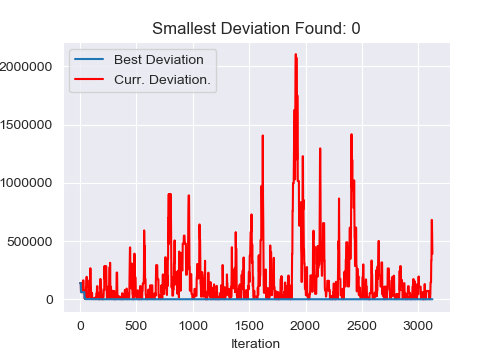

In [15]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")


# we can plot the progress of the search for visualization
# plot search convergence
curr = np.array(trajectory)
best = np.array(trajectory_best)
fig = plt.figure(figsize=(5, 3.5))
line_min, = plt.plot(curr[:,0], curr[:,1], label='Curr. Deviation.',color='red')
line_curr, = plt.plot(best[:,0],best[:,1], label='Best Deviation')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.legend(handles=[line_curr, line_min])
plt.title('Smallest Deviation Found: {:d}'.format(int(best_f)));

## Simulated Annealing - the simanneal package

When we use the simanneal package, we need to take the code that we had in our own functions before and put it inside special functions that simanneal understands. The simanneal package uses two functions - move() and energy(). These correlate with the reassign_one() and balance_metric() functions. The move function handles whatever change you're making. It's job is to make the change, and possibly to enforce constraints. (Either function can enforce constraints, depending on the method used.) The energy's job is to just return the current score.

The nice part about the simanneal package is that it does all your comparisons for you. You don't have to write any code to compare your current state and new state. That happens "behind the scenes."

Let's talk a little bit about "state." State is the current snapshot of whatever values you're **changing**. If we said we had an assignment of job 1 to process A and job 2 to process B, the assignments are the current state not the jobs. We need the jobs to determine energy. But, the jobs don't change at all. They stay the same. So they aren't part of the state. (Even if we put job 1 and job 2 on process B, we still just have job 1 and job 2. We aren't going to suddenly have an extra job.)

We still need our jobs to be available to us in the simanneal package. So we'll pass it in as another variable when we initialize the package.

Let's see how it's done.

In [16]:
#this line just imports the package
from simanneal import Annealer

#this is the line where we decide what we're calling this problem
class loadProblem(Annealer):

    # Here's where we pass extra data if we need it. We need to pass our times (jobs) variable and the number of servers (k)
    def __init__(self, state, times, k):
        #this line makes the times accessible within the other two functions
        self.times = times
        self.k = k
        #this is how we initialize - note we're calling super with the same name as above (loadProblem)
        super(loadProblem, self).__init__(state)  # important!

    def move(self):
        """This corresponds to our previous reassign one function"""
        # pick one of the jobs and assign it to one of k processors
        
        #copy the state & set up variables
        assign = self.state
        n = len(assign)
        k = self.k
        # choose a job and a new processor assignment
        which_job = np.random.randint(0,n,1)[0]
        which_proc = np.random.randint(0,k,1)[0]
        assign[which_job] = which_proc
        
        #we don't return anything this time, we just update the state
        self.state = assign
        
    
    def energy(self):
        """This corresponds to our balance_metric function"""
        times = self.times
        assign = self.state
        k = self.k
        target = sum(times)/k
        return sum( (sum(times[assign==j])-target)**2 for j in range(k) )


#initialize the class
ld = loadProblem(assign, times, k)
ld.set_schedule(ld.auto(minutes=.2)) #set approximate time to find results

# since our state is a numpy array, we need deepcopy
ld.copy_strategy = "deepcopy" 
#this is what kicks it off
best_assign, best_score = ld.anneal()



print('The best set is: ', best_assign)

print('The best score is:', best_score) 

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   220.00000        144.50    49.95%     0.00%     0:00:02     0:00:001 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   220.00000        180.50    49.69%     0.00%     0:00:12     0:00:003

The best set is:  [0 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 0 0]
The best score is: 0.5


## Genetic Algorithms

Remember that the pseudocode for genetic algorithms looks like this:

```
generate the initial population
compute fitness
repeat
    selection
    crossover
    mutation
    compute fitness
until population has converged
```

We're once again going to use the DEAP package to see if we can get our loads balanced. For this problem, we'll need to think about what it means to do selection, crossover, and mutation. But first, let's talk about individuals and populations. 

The "individual" in the genetic algorithm is one potential assignment of jobs to processors. A population is a bunch of potential assignments. DEAP gets more complicated when using numpy data structures. So for this version of the problem we're going to convert our numpy data structures back to regular lists when we're passing them around.

Let's create a function for returning the random assignments. We'll need to pass in $k$ - the number of processors and $n$ - the number of jobs.




In [17]:
def create_individual(k,n):
    current_x = np.random.randint(low=0,high=k,size=n)
    return current_x.tolist() #this converts our np array back to a list

#let's test this function
assign = create_individual(k,n)
assign

[1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0]

We will also need a function for assessing the value. We've already written that, but DEAP expects a tuple, so we need a modified version. We'll also need to cast our list back to a numpy array to get this code to work correctly.

In [18]:
# objective function = total squared deviation of times from balanced times
def balance_metric_tuple(assign,times,k):
    #make the list a numpy array
    assign_np = np.array(assign)
    target = sum(times)/k
    return (sum( (sum(times[assign_np==j])-target)**2 for j in range(k) ), ) #note that we're returning a tuple

#let's test this function
balance_metric_tuple(assign,times,k)

(37264.5,)

### Creator
Now we're ready to start working with DEAP. First we need to import some things and use the creator to create some objects to work with.

In [19]:
import random
from deap import base
from deap import creator
from deap import tools
from functools import partial

#create a FitnessLoad class. This inherits from the base fitness class. 
#Use (-1,) for the weight for minimizing, use (1.0,) for maximizing
# the name is whatever you want to call this instance of DEAP
creator.create("FitnessLoad", base.Fitness, weights=(-1.0,))

#our individuals are lists, so we'll create the Individual class as inheriting from list
#and we'll tell it we're using our fitness class
#this line will need to match the class name that you set above.
creator.create("Individual", list, fitness=creator.FitnessLoad)

### Toolbox
Now we have to set up the toolbox. The toolbox is how we set up the custom attributes for this problem. DEAP has a lot of options for how you set up the toolbox and it can get pretty confusing. The first thing we're going to do is just configure the toolbox.

After we have a toolbox, we can register things to it and unregister them. 

We need to register a way to create individuals. We first have to register a way to make assignments. We'll do that by registering an function called assignments and telling DEAP that whenever it's called, DEAP should turn around and call our create_individual function, with the fixed $k$ adn $n$ variables.

We can test that this is working by using the tool.initIterate command, telling it we expect a list back, and telling it to call the toolbox.assignments function.

If you run this code multiple times, you'll see that we get a different set of assignments each time.

In [20]:
# this line just configures a toolbox, we can register and unregister things in the toolbox
#this line won't change in your code
toolbox = base.Toolbox()

#This line tells DEAP that we need to use the create_individual function to create our individuals
#note that we pass in the k and n that our function needs here, too
#this line WILL change in your homework to call your create_individual function and whatever additional paramters it needs
toolbox.register("assignments",create_individual,k,n)

#test this - it should look like a familiar list of random assignments
tools.initIterate(list, toolbox.assignments)

[1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1]

Now that we know that we are getting valid assignments, we need to register an "individual" function with DEAP. The following line of code tells DEAP that we're going to iteratively call the assignments function each time we need to create a new individual. (Note that we're setting tool.initIterate here - which is the same way we tested it above.)

We also need to tell DEAP how we want to build our populations. Notice here that we're saying that our population will be made of individuals, they'll each be of type list, and that we'll repeatedly call the toolbox.individual function. The parameter initRepeat means that we'll need to tell DEAP how many times to repeat when we build our population. (We'll set that later.)

In [21]:
#tell DEAP how we're going to build our individuals
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.assignments)
#test our individual function
print('An individual:\n', toolbox.individual())

#tell DEAP how we're going to build our populations
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

#test our population function, generating 3 individuals
print('Our population: \n', toolbox.population(n=3))

An individual:
 [1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1]
Our population: 
 [[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1], [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0], [1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0]]


Next we need to register our function to evaluate an assignment. This function will automatically get an individual, but we need to pass in some extra data - the times and the number of processors $k$. We can test that our function is working in the toolbox by manually passing in an individual.

In [22]:
#register the evaulation function, and pass in the extra parameters
#this will CHANGE for your homework
toolbox.register("evaluate", balance_metric_tuple, times=times, k=k)

#to test this, we have to pass in an individual
toolbox.evaluate(toolbox.individual())

(209304.5,)

We're finally at the point where we can talk about selection, mating (crossover) and mutation! 

#### Selection
Selection first. We're going to use tournament selection. That means that DEAP will select the best individual among a sub-group of randomly chosen individuals from the population. It will do that $k$ times. (Note this is a different $k$ than we've used before.) If the sub-group size is the same as the population size, it's basically nullifying the selection process, so you'll want to choose a sub-group size smaller than your population size.

Tournament selection is pretty standard and should work for your homework, though you may want to play with the tournsize. Larger values will promote the best individuals, but will also decrease diversity.

Let's see how it works.


In [23]:
#create a test population with 5 individuals
test_pop = toolbox.population(n=5)

#print the test population
print('Test population:\n', test_pop)

# Selection - selecting a sub-group of 3 of our population
toolbox.register("select", tools.selTournament, tournsize=3)


print('The best 3 individuals found in our group of 5 is:\n', toolbox.select(test_pop, k=3))



Test population:
 [[1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0], [0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1], [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0], [0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0], [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]]
The best 3 individuals found in our group of 5 is:
 [[0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1], [1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0], [0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0]]


#### Mating (Crossover)
Crossover takes two individuals and "mates" them by swapping individual values within the individual. There are multiple methods for performing crossover. The easiest method for the kind of data we have (lists of integers) is the cxTwoPoint crossover strategy. In this strategy, you have two individuals, and each individual "swaps" a value with the other one.

In your homework, you'll need to CHANGE the crossover method to suit your problem:(https://deap.readthedocs.io/en/master/api/tools.html)

We'll register the cxTwoPoint strategy and test it. Can you see which jobs got swapped?

In [24]:
#register cxTwoPoint strategy
# Crossover
toolbox.register("mate", tools.cxTwoPoint)

#test the strategy
ind1 = toolbox.individual()
ind2 = toolbox.individual()

print('Before crossover:\n')
print(ind1)
print(ind2)

after = toolbox.mate(ind1, ind2)
print('After crossover: \n')
print(after[0])
print(after[1])

Before crossover:

[0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0]
[0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1]
After crossover: 

[0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0]
[0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1]


#### Mutation
Finally, we have mutation. Mutation in genetic algorithms works like mutation in life - it's some random change to the existing state. For this problem, we could choose between 2 mutation options:
* mutShuffleIndexes 
* mutUniformInt

ShuffleIndexes randomly shuffles the assignments. This would result in the same number of processors assigned, but different jobs assigned to each processor.

UniformInt randomly changes the assignments to an integer between 0 and k-1. This could result in more total jobs on a processor than when we started. 

The indpb is the indepedent probability for each value to be changed. Setting this low means that some of our assignments will stay the same. If we set this to 1, we'd essentially be starting over with a completely random individual.

We'll test both so you can see what happens with each. But, ultimately, we'll use mutUniformInt.

In [25]:
# Mutation
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=.1)

#test the strategy
ind1 = toolbox.individual()
print('Before:\n', ind1, 'Zeros:', sum(1 for i in ind1 if i == 0), 'Ones:', sum(1 for i in ind1 if i == 1) )
ind2 = toolbox.mutate(ind1)[0]
print('After:\n', ind2, 'Zeros:', sum(1 for i in ind2 if i == 0), 'Ones:', sum(1 for i in ind2 if i == 1) )

toolbox.register("mutate", tools.mutUniformInt, low = 0, up = k-1, indpb=0.1)
#test the strategy
ind1 = toolbox.individual()
print('Before:\n', ind1, 'Zeros:', sum(1 for i in ind1 if i == 0), 'Ones:', sum(1 for i in ind1 if i == 1) )
ind2 = toolbox.mutate(ind1)[0]
print('After:\n', ind2, 'Zeros:', sum(1 for i in ind2 if i == 0), 'Ones:', sum(1 for i in ind2 if i == 1) )


Before:
 [1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0] Zeros: 10 Ones: 10
After:
 [1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0] Zeros: 10 Ones: 10
Before:
 [0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0] Zeros: 11 Ones: 9
After:
 [0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0] Zeros: 10 Ones: 10


#### Stats
DEAP offers handy ways to track a bunch of statistics. These don't generally change much. You should be able to just pop them into your code.

In [26]:
# configure statistics to collect (no changes needed here)
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

## Helper Function

All of the above was an explanation of set up. When it comes time to actually run the code, we can use the wrapper function that was created in the lesson. Note that this version of the wrapper function is a little different than the lesson's, in that it passes in the toolbox, tools, and stats instead of using the ones we created in the global scope.

When it comes time to combine GA with local search, you'll need to make a new custom function like this one. Be sure to read through it to understand what it's doing.

In [27]:

# no changes here, call this to execute the genetic algorithm
def customGA(in_toolbox,in_tools,in_stats,pop_size, cx_prob, mut_prob, max_gen, max_no_improve):

    pop = in_toolbox.population(n=pop_size)
    logbook = in_tools.Logbook()
    hof = in_tools.HallOfFame(1)

    # Evaluate the entire population
    fitnesses = list(map(in_toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    hof.update(pop)
    best_val = hof[0].fitness.values
    num_no_improve = 0
    generation = 0

    while num_no_improve < max_no_improve and generation < max_gen:

        # Select the next generation individuals
        selected = in_toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(in_toolbox.clone, selected))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cx_prob:
                in_toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < mut_prob:
                in_toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(in_toolbox.evaluate, invalid_ind)
        num_evals = 0
        for ind, fit in zip(invalid_ind, fitnesses):
            num_evals += 1
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring

        # track the best value and reset counter if there is a change
        hof.update(pop)
        curr_best_val = hof[0].fitness.values[0]
        num_no_improve += 1
        if curr_best_val != best_val:
            best_val = curr_best_val
            num_no_improve = 0

        # record stats
        record = in_stats.compile(pop)
        logbook.record(gen=generation, evals=num_evals, **record)

        # increment generation
        generation += 1

    best_x = list(hof[0])

    return best_val, best_x, logbook

### Putting GA All Together

The next cell is mostly a repeat of what we have broken out into multiple cells above. This is provided all together as a convenience. 

In [28]:
n = 20
k = 2
# how we create our individuals
def create_individual(k,n):
    current_x = np.random.randint(low=0,high=k,size=n)
    return current_x.tolist() #this converts our np array back to a list

# objective function = total squared deviation of times from balanced times
def balance_metric_tuple(assign,times,k):
    #make the list a numpy array
    assign_np = np.array(assign)
    target = sum(times)/k
    return (sum( (sum(times[assign_np==j])-target)**2 for j in range(k) ), ) #note that we're returning a tuple


#create a FitnessLoad class. This inherits from the base fitness class. 
#Use (-1,) for the weight for minimizing, use (1.0,) for maximizing
# the name is whatever you want to call this instance of DEAP
creator.create("FitnessLoad", base.Fitness, weights=(-1.0,))

#our individuals are lists, so we'll create the Individual class as inheriting from list
#and we'll tell it we're using our fitness class
#CHANGE - this line will need to match the name of your class instance in your homework
creator.create("Individual", list, fitness=creator.FitnessLoad)

# this line just configures a toolbox, we can register and unregister things in the toolbox
#this line won't change in your code
toolbox = base.Toolbox()

#This line tells DEAP that we need to use the create_individual function to create our individuals
#note that we pass in the k and n that our function needs here, too
#this line WILL change in your homework to call your create_individual function and whatever additional paramters it needs
toolbox.register("assignments",create_individual,k,n)

#tell DEAP how we're going to build our individuals & Populations
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.assignments)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
#register the evaulation function, and pass in the extra parameters
#this will CHANGE for your homework
toolbox.register("evaluate", balance_metric_tuple, times=times, k=k)

# Selection (don't change except possibly tournsize, larger size will promote 
# the best individuals but also decrease diversity)
toolbox.register("select", tools.selTournament, tournsize=3)

# Crossover - CHANGE this to suit your problem (https://deap.readthedocs.io/en/master/api/tools.html)
toolbox.register("mate", tools.cxTwoPoint) 

# Mutation - CHANGE this to suit your problem
toolbox.register("mutate", tools.mutUniformInt, low = 0, up = k-1, indpb=0.1)

# configure statistics to collect (no changes needed here)
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)



C:\Users\deann\.conda\envs\ds775\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessLoad' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\deann\.conda\envs\ds775\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


### Calling the code
It's finally time to call the genetic algorithm code. To do so, we'll need to set up some additional parameters and then call our custom_ga function, passing in the toolbox, tools, stats and our parameters.

The function returns our best balance, our best assignment, and a log of what it took to get there.


In [29]:
# define search parameters
pop_size = 200
crossover_prob = 0.3
mutation_prob = 0.5
max_gen = 2000
max_no_improve = 200

# get solution
best_balance, best_assign, log = customGA(toolbox,tools,stats, pop_size, crossover_prob, mutation_prob,
                                     max_gen, max_no_improve)

print('Best Assignments:', best_assign)
print('Times on each processor', [ sum(times[np.array(best_assign)==j]) for j in range(k)])
print('The best balance was', best_balance)


Best Assignments: [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]
Times on each processor [1187, 1188]
The best balance was (0.5,)


## Increasing Problem Size

We used a very small problem to demonstrate each of the methods above. Now it's time to create a much larger problem and see how our algorithms perform. 

In [30]:
####################################
# Setting up a new bigger problem
####################################
n = 1000
k = 10
#we're going to set some min/max times here for the jobs
min_time = 20
max_time = 200
#randomly generate some jobs
times = np.random.randint(low=min_time, high = max_time, size = n)

### Baseline
Let's see what our baseline deviation from balanced loads is with a size this large. (Note, there's randomness here and some algorithms set their own baseline. But this should give us a general idea.)


In [39]:
#get the baseline
assign = np.random.randint(low=0,high=k,size=n)
baseline = balance_metric(assign,times,k)
print('Baseline with random assignments:', baseline)
print('Total time on each processor:', [ sum(times[assign==j]) for j in range(k)])

Baseline with random assignments: 13724568.0
Total time on each processor: [8432, 10678, 10863, 10710, 10114, 12573, 11369, 10845, 10559, 12847]


### Greedy local search
The only parameter we can fiddle with in our greedy local search is how many iterations we're willing to go with no improvement. Try changing the 5000 number to see if it gets better results

* max_no_improve = 5000

In [32]:
#### Greedy Local Search #####
#####################
#Parameters
max_no_improve = 5000
#####################
best_assign, best_f, num_iter = load_balance_local(times,k,max_no_improve)
print('Greedy Local Search best result:', best_f)
print('Total time on each processor:', [ sum(times[best_assign==j]) for j in range(k)])

Greedy Local Search best result: 890.0
Total time on each processor: [10886, 10918, 10907, 10890, 10906, 10892, 10899, 10903, 10900, 10889]


### Custom Simulated Annealing
For our custom simulated annealing, we can tweak the following parameters:
* max_no_improve = 1000
* temp = 500
* alpha = .99 

Try tweaking these parameters to see if you can get a better result


In [33]:
#### Custom Simulated Annealing ####
#####################
#Parameters
max_no_improve = 1000
temp = 500 
alpha = .99
#####################


best_x, best_f, iterations, trajectory, trajectory_best = custom_simanneal(times, k, max_no_improve, temp, alpha)
print('Custom Simulated Annealing best result:', best_f)
print('Total time on each processor:', [ sum(times[best_x==j]) for j in range(k)])

Custom Simulated Annealing best result: 2540130.0
Total time on each processor: [11067, 10932, 11394, 10808, 10316, 11124, 10242, 10079, 11457, 11571]


### Simanneal Package
The only parameter you can tweak in the simanneal package is how long you're willing to wait. Try changing that to see if you can get a better result.
* wait_time = .2

In [34]:
#### Simanneal Package ####
#####################
#Parameters
wait_time = .2
#####################

assign = np.random.randint(low=0,high=k,size=n)
ld = loadProblem(assign, times, k)
ld.set_schedule(ld.auto(minutes=wait_time)) 
ld.copy_strategy = "deepcopy" 
best_assign, best_score = ld.anneal()
print('Simanneal Package best result', best_score)
print('Total time on each processor:', [ sum(times[best_assign==j]) for j in range(k)])

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   100.00000        458.00    10.00%     0.00%     0:00:25    -1:59:527 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   100.00000        674.00    12.50%     0.00%     0:00:13     0:00:001

Simanneal Package best result 458.0
Total time on each processor: [10896, 10888, 10910, 10887, 10905, 10899, 10903, 10900, 10902, 10900]


### DEAP Genetic Algorithm
DEAP has a lot of parameters to tweak. Try tweaking some of the following to see if you can get a better result.

* pop_size = 200
* crossover_prob = 0.3
* mutation_prob = 0.5
* max_gen = 2000
* max_no_improve = 200

(*Note*: that we need to repeat a lot of code when we're changing the problem space with DEAP. DEAP hard-codes the k and n in our functions when we set it up, so we need to essentially start from scratch. We've included all the necessary code without comments in the cell below.) 

**Warning**: This code will be slow to run.

In [35]:
#### DEAP Genetic Algorithm ####
####################
#Parameters
pop_size = 200
crossover_prob = 0.3
mutation_prob = 0.5
max_gen = 2000
max_no_improve = 200
#####################


###################################
# Leave everything below here alone
###################################

# how we create our individuals
def create_individual(k,n):
    current_x = np.random.randint(low=0,high=k,size=n)
    return current_x.tolist() #this converts our np array back to a list

# objective function = total squared deviation of times from balanced times
def balance_metric_tuple(assign,times,k):
    #make the list a numpy array
    assign_np = np.array(assign)
    target = sum(times)/k
    return (sum( (sum(times[assign_np==j])-target)**2 for j in range(k) ), ) #note that we're returning a tuple

creator.create("FitnessLoad", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessLoad)
toolbox = base.Toolbox()
toolbox.register("assignments",create_individual,k,n)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.assignments)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", balance_metric_tuple, times=times, k=k)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxTwoPoint) 
toolbox.register("mutate", tools.mutUniformInt, low = 0, up = k-1, indpb=0.1)
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# get solution
best_balance, best_assign, log = customGA(toolbox,tools,stats, pop_size, crossover_prob, mutation_prob,
                                     max_gen, max_no_improve)

print('Genetic Algorithm Best Result', best_balance)
print('Total time on each processor:', [ sum(times[np.array(best_assign)==j]) for j in range(k)])

Genetic Algorithm Best Result 6010.0
Total time on each processor: [10913, 10945, 10905, 10911, 10907, 10891, 10858, 10911, 10861, 10888]
